## Outline of steps
* [step0](#step0): import necessary packages
* [step1](#step1): import dataset `part3_dataset.pickle` as `part4_dataset`
* [step2](#step2): discretize the Reviewer_Score into binary output for sentiment analysis
* [step3](#step3): implement Box-Cox transformation to target variable Reviewer_Score
* [step4](#step4): compute the quarterly average score (using transformed_score)
* [step5](#step5): compute the change rate of quarterly average score
* [step6](#step6): merge quarterly average score(C) to original dataset(group_dataset)
* [step7](#step7): plot the correlation matrix between `transformed_score` with the derived features
* [step8](#step8): save the output(`group_dataset`) as part4_dataset.pickle

In [3]:
# import necessary packages
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno # module for missing value visualization
from scipy import stats # implement box-cox transformation

# Pretty display for notebooks
%matplotlib inline

<a id="step1"></a>
## step1: import dataset part3_dataset.pickle

In [4]:
part4_dataset = pd.read_pickle("part3_dataset.pickle")

<a id="step2"></a>
## step2: discretize the Reviewer_Score into binary output for sentiment analysis

For the score scaling ranges from 0 to 10, in the first guess, use **6** as the splitting point for positive/negative review.<br/>

In [5]:
# discretize the Reviewer_Score into binary output for sentiment analysis
part4_dataset["review_sentiment"] = [1 if x > 6 else 0 for x in part4_dataset["Reviewer_Score"]]
part4_dataset.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,review_sentiment
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,0
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,1
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,1
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,0
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,1


<a id="step3"></a>
## step3: implement Box-Cox transformation to target variable `Reviewer_Score` and relavant explanatory numerical variables
These explanatory features being transformed include:
1. Average_Score
2. Review_Total_Negative_Word_Counts
3. Review_Total_Positive_Word_Counts
<br/>

Because the box-cox transformation requires all values must be positive, but there are some 0 values in Review_Total_Negative_Word_Counts and Review_Total_Positive_Word_Counts, I will jitter them to 0.0001 to avoid the problem.

Ref:
* [scipy boxcox transformation](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.boxcox.html)
* [scipy boxcox specify lmbda on your own](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox.html)
* [scipy inverse boxcox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html)


In [18]:
# specify the columns to be transformed and their new names
transform_list = ["Reviewer_Score", "Average_Score",
                  "Review_Total_Negative_Word_Counts","Review_Total_Positive_Word_Counts"]

new_col_name = ["transformed_score","transformed_average_score",
                "transformed_review_total_negative_word_counts","transformed_review_total_positive_word_counts"]

In [19]:
# try to jitter 0 values to 0.0001 in Review_Total_Negative_Word_Counts and Review_Total_Positive_Word_Counts
value = {0:0.0001}

part4_dataset.replace({"Review_Total_Negative_Word_Counts":value,
                       "Review_Total_Positive_Word_Counts":value}, inplace=True)

* [The replace method reference](https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict)

In [26]:
# implement box-cox transformation on the 4 columns
for i in range(4):
    array, maxlog = stats.boxcox(part4_dataset[transform_list[i]])
    print("the box-cox lmbda that maximizes the log-likelihood function for {} is {:.2f}".format(transform_list[i], maxlog))
    part4_dataset[new_col_name[i]] = array

the box-cox lmbda that maximizes the log-likelihood function for Reviewer_Score is 3.30
the box-cox lmbda that maximizes the log-likelihood function for Average_Score is 3.75
the box-cox lmbda that maximizes the log-likelihood function for Review_Total_Negative_Word_Counts is 0.19
the box-cox lmbda that maximizes the log-likelihood function for Review_Total_Positive_Word_Counts is 0.32


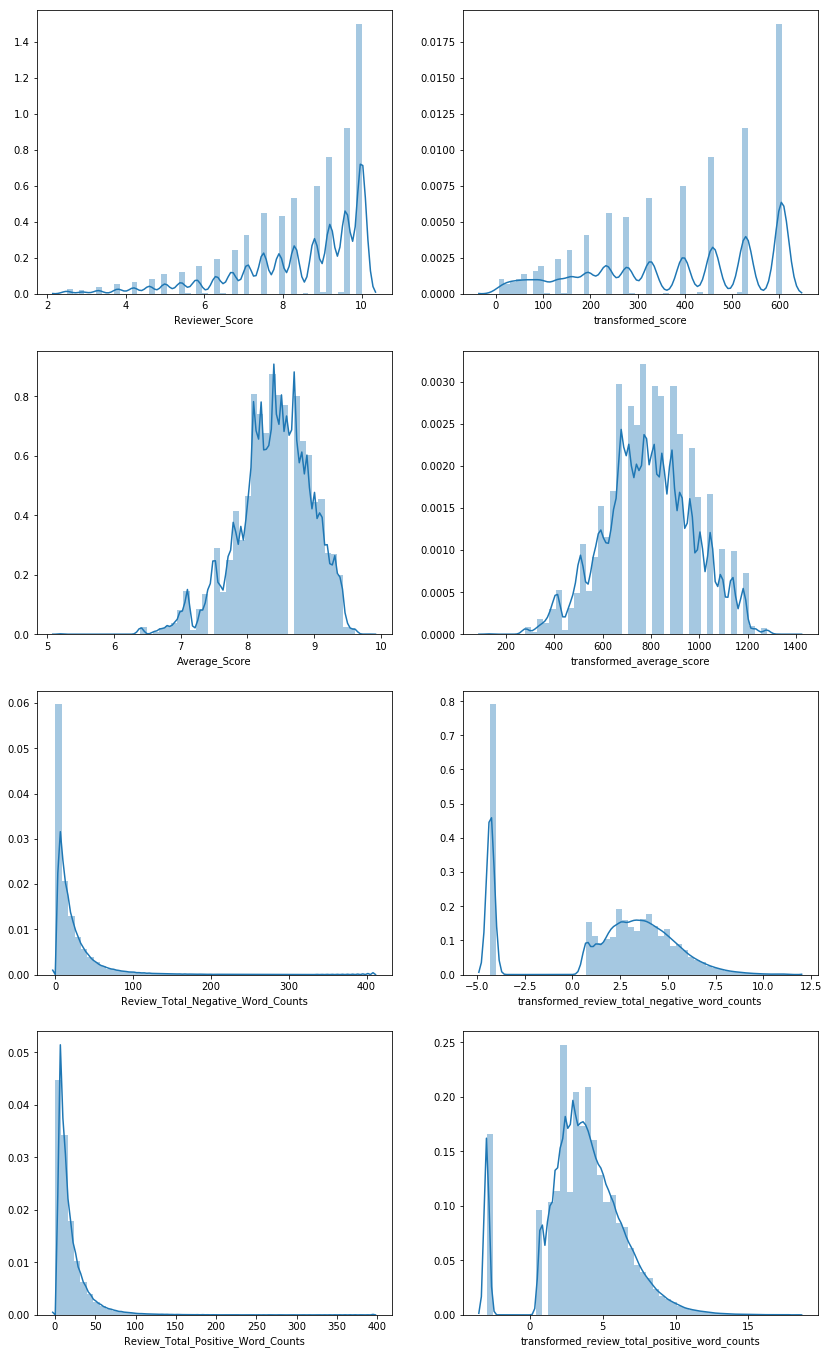

In [31]:
# plot the distribution before/after the transformation
fig, axes = plt.subplots(4,2)
# axes = axes.flatten()
fig.set_size_inches(14,24)

# use axlabel to specify the label name for x-axis
for i in range(4):
    sns.distplot(part4_dataset[transform_list[i]], axlabel = transform_list[i], ax = axes[i,0])
    sns.distplot(part4_dataset[new_col_name[i]], axlabel = new_col_name[i], ax = axes[i,1])

<a id="step4"></a>
## step4: compute the quarterly average score (using transformed_score)
Because in the linear modeling for prediction, I will only use the `transformed_score` as the target variable, it is better to compute the derived score features all from `transformed_score` for the sake of consistency.

In [32]:
# compute the quarterly average transformed score
group_dataset = part4_dataset

# change Hotel_Name to catogorical variable - for the purpose of efficiency
group_dataset["Hotel_Name"] = group_dataset["Hotel_Name"].astype("category")
group_dataset.info()

# subset original dataset for ease of data munging
group_subset = group_dataset[["Hotel_Name","Review_Date","transformed_score"]].set_index("Review_Date")

# convert the dataframe into period dataframe
period_group_subset = group_subset.to_period(freq="Q") # already set the Review_Date as index earlier
print(period_group_subset[:10])
print(period_group_subset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511944 entries, 0 to 515737
Data columns (total 22 columns):
Hotel_Address                                    511944 non-null object
Additional_Number_of_Scoring                     511944 non-null int64
Review_Date                                      511944 non-null datetime64[ns]
Average_Score                                    511944 non-null float64
Hotel_Name                                       511944 non-null category
Reviewer_Nationality                             511944 non-null object
Negative_Review                                  511944 non-null object
Review_Total_Negative_Word_Counts                511944 non-null float64
Total_Number_of_Reviews                          511944 non-null int64
Positive_Review                                  511944 non-null object
Review_Total_Positive_Word_Counts                511944 non-null float64
Total_Number_of_Reviews_Reviewer_Has_Given       511944 non-null int64
Reviewer_Score 

<a id="step5"></a>
## step5: compute the change rate of quarterly average score

In [33]:
# compute the change rate of quarterly average transformed score
A = period_group_subset.groupby(["Hotel_Name","Review_Date"]).mean()

# compute lag 1 data
B = A.groupby("Hotel_Name").shift(1)
B.rename(columns={"transformed_score":"previous_transformed_score"}, inplace=True)

# concatenate both dataset
C = pd.concat([A,B], axis=1)
display(C[:15])

C["change_rate"] = C["transformed_score"]/C["previous_transformed_score"] - 1
display(C[:15])

transformed_score  previous_transformed_score
Hotel_Name         Review_Date                                               
11 Cadogan Gardens 2015Q3              374.626962                         NaN
                   2015Q4              329.882564                  374.626962
                   2016Q1              315.121172                  329.882564
                   2016Q2              469.514386                  315.121172
                   2016Q3              465.418729                  469.514386
                   2016Q4              457.635775                  465.418729
                   2017Q1              484.707731                  457.635775
                   2017Q2              434.140038                  484.707731
                   2017Q3              462.419827                  434.140038
1K Hotel           2015Q3              292.580843                         NaN
                   2015Q4              313.744028                  292.580843
                   2016Q1              311.515939                  313.744028
                   2016Q2              310.512878                  311.515939
                   2016Q3              314.391409                  310.512878
                   2016Q4              282.536429                  314.391409

transformed_score  previous_transformed_score  \
Hotel_Name         Review_Date                                                  
11 Cadogan Gardens 2015Q3              374.626962                         NaN   
                   2015Q4              329.882564                  374.626962   
                   2016Q1              315.121172                  329.882564   
                   2016Q2              469.514386                  315.121172   
                   2016Q3              465.418729                  469.514386   
                   2016Q4              457.635775                  465.418729   
                   2017Q1              484.707731                  457.635775   
                   2017Q2              434.140038                  484.707731   
                   2017Q3              462.419827                  434.140038   
1K Hotel           2015Q3              292.580843                         NaN   
                   2015Q4              313.744028                  292.580843   
                   2016Q1              311.515939                  313.744028   
                   2016Q2              310.512878                  311.515939   
                   2016Q3              314.391409                  310.512878   
                   2016Q4              282.536429                  314.391409   

                                change_rate  
Hotel_Name         Review_Date               
11 Cadogan Gardens 2015Q3               NaN  
                   2015Q4         -0.119437  
                   2016Q1         -0.044747  
                   2016Q2          0.489949  
                   2016Q3         -0.008723  
                   2016Q4         -0.016722  
                   2017Q1          0.059156  
                   2017Q2         -0.104326  
                   2017Q3          0.065140  
1K Hotel           2015Q3               NaN  
                   2015Q4          0.072333  
                   2016Q1         -0.007102  
                   2016Q2         -0.003220  
                   2016Q3          0.012491  
                   2016Q4         -0.101323

<a id="step6"></a>
## step6: merge quarterly average score(C) to original dataset(group_dataset) 

In [34]:
# merge quarterly average score(C) to original dataset(group_dataset)
# reset index and rename columns in C
print("original C index")
print(C.info())
C.reset_index(inplace=True)

print("\n")
print("reset C index")
print(C.info())

# rename C columns
C.rename(columns={"Review_Date":"review_quarter",
                  "transformed_score":"quarter_transformed_score",
                  "previous_transformed_score":"quarter_previous_transformed_score",
                  "change_rate":"quarter_change_rate"}, inplace=True)

print("\n")
print("new C column names")
print(C.info())

original C index
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13275 entries, (11 Cadogan Gardens, 2015Q3) to (pentahotel Vienna, 2017Q3)
Data columns (total 3 columns):
transformed_score             12569 non-null float64
previous_transformed_score    11138 non-null float64
change_rate                   11030 non-null float64
dtypes: float64(3)
memory usage: 405.0 KB
None


reset C index
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13275 entries, 0 to 13274
Data columns (total 5 columns):
Hotel_Name                    13275 non-null category
Review_Date                   13275 non-null object
transformed_score             12569 non-null float64
previous_transformed_score    11138 non-null float64
change_rate                   11030 non-null float64
dtypes: category(1), float64(3), object(1)
memory usage: 492.4+ KB
None


new C column names
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13275 entries, 0 to 13274
Data columns (total 5 columns):
Hotel_Name                    

In [35]:
# create a new quarterly column from `Review_Date` as key for merge
group_dataset["review_quarter"] = pd.PeriodIndex(group_dataset.Review_Date, freq="Q")

# join group_dataset and C
group_dataset = pd.merge(left=group_dataset, right=C, \
                         left_on=["Hotel_Name","review_quarter"], right_on=["Hotel_Name","review_quarter"], \
                         how="left")

# have a look at the final joined table
display(group_dataset[:2])
display(group_dataset.info())

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,lng,review_sentiment,transformed_score,transformed_average_score,transformed_review_total_negative_word_counts,transformed_review_total_positive_word_counts,review_quarter,quarter_transformed_score,quarter_previous_transformed_score,quarter_change_rate
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397.0000,1403,Only the park outside of the hotel was beauti...,...,4.915968,0,9.874149,559.708433,11.310164,3.610293,2017Q3,288.502518,290.299057,-0.006189
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0.0001,1403,No real complaints the hotel was great great ...,...,4.915968,1,233.955126,559.708433,-4.288693,10.756478,2017Q3,288.502518,290.299057,-0.006189


<class 'pandas.core.frame.DataFrame'>
Int64Index: 511944 entries, 0 to 511943
Data columns (total 26 columns):
Hotel_Address                                    511944 non-null object
Additional_Number_of_Scoring                     511944 non-null int64
Review_Date                                      511944 non-null datetime64[ns]
Average_Score                                    511944 non-null float64
Hotel_Name                                       511944 non-null category
Reviewer_Nationality                             511944 non-null object
Negative_Review                                  511944 non-null object
Review_Total_Negative_Word_Counts                511944 non-null float64
Total_Number_of_Reviews                          511944 non-null int64
Positive_Review                                  511944 non-null object
Review_Total_Positive_Word_Counts                511944 non-null float64
Total_Number_of_Reviews_Reviewer_Has_Given       511944 non-null int64
Reviewer_Score 

None

<a id="step7"></a>
## step7: plot the correlation matrix between `transformed_score` with the derived features (`quarter_transformed_score`, `quarter_previous_transformed_score` and `quarter_change_rate`)
As I am now setting `transformed_score` as the target variable for linear prediction modeling, the correlation matrix shows up that `transformed_score` is strong correlated to `Reviewer_Score` and `review_sentiment`. These are understandable, because `transformed_score` and `review_sentiment` are derived features from `Reviewer_Score`.
<br/><br/>
The other ambition is that I hope to use historical `quarter_transformed_score`, `quarter_previous_transfromed_score` and `quarter_change_rate` to predict `transformed_score`. But based on the correlation matrix, these features only show up mild correlation to `transformed_score`.
<br/><br/>
The brief correlation list of possibly useful predictors for target variable `transformed_score`:
1. `review_sentiment` vs `transformed_score`: 0.6
2. `quarter_transformed_score` vs `transformed_score`: 0.41
3. `Average_Score` vs `transformed_score`: 0.37
4. `Review_Total_Negative_Word_Counts` vs `transformed_score`: -0.37
5. `quarter_previous_transformed_score` vs `transformed_score`: 0.34
6. `Review_Total_Positive_Word_Counts` vs `transformed_score`: 0.22

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5]),
 <a list of 17 Text xticklabel objects>)

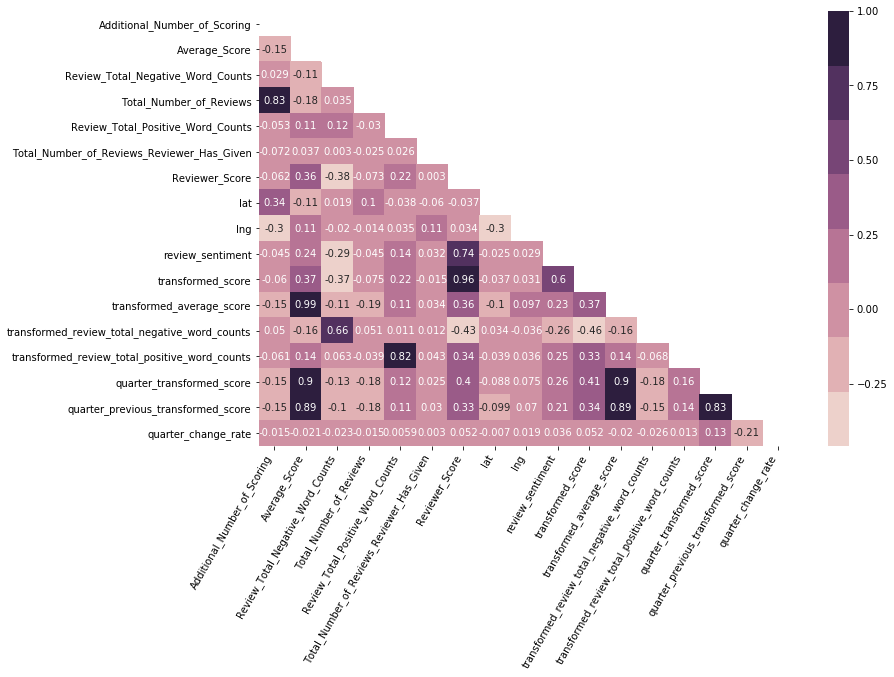

In [39]:
# plot the correlation matrix between Reviewer_Score with the derived features such as transformed_score, previous_transformed_score and change_rate
plt.figure(figsize=(12,8)) 

corr = group_dataset.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# correlation function will detect and neglect the categorical features
sns.heatmap(group_dataset.corr(), cmap = sns.cubehelix_palette(8), annot = True, mask = mask)
plt.xticks(rotation=60, ha='right')

<a id="step8"></a>
## step8: save the output as part4_dataset.pickle

In [37]:
# group_dataset is the final joined table instead of part4_dataset in the end
group_dataset.to_pickle("part4_dataset.pickle")